In [1]:
import pandas as pd
import os
from tqdm import tqdm
import datetime
import matplotlib.pyplot as plt
import numpy as np
from scipy.interpolate import interp1d

## Functions

In [2]:
def plot_postwait_per_day(df_post, attractions, date):
    fig, ax = plt.subplots()
    for attraction in attractions:
        (df_post.query("attraction == @attraction and date == @date")
                .plot(x = 'minute_of_day', 
                            y = 'SPOSTMIN',
                            label = attraction,
                            ax = ax))
    return fig, ax

## Step 1: Read in and summarize the data

In [3]:
loc = os.path.join('..', 'data', 'waiting times')

dfs = list()
for filename in tqdm(os.listdir(loc)):
    df = pd.read_csv(os.path.join(loc, filename))
    df['attraction'] = filename.replace('.csv', '')
    dfs.append(df.copy())

df_raw = pd.concat(dfs, ignore_index=True)

  0%|          | 0/52 [00:00<?, ?it/s]

100%|██████████| 52/52 [00:07<00:00,  6.75it/s]


### Preprocess & clean data

In [4]:
df = df_raw.copy()

df['datetime'] = pd.to_datetime(df['datetime'], format='%Y-%m-%d %H:%M:%S')
df['minute_of_day'] = (df['datetime'].dt.minute 
                        + 60 * (df['datetime'] - datetime.timedelta(minutes = 3 * 60)).dt.hour
                        + 3 * 60)

## Step 2: Validate the data with some visuals

#### Split data into posted and actual waiting time

In [5]:
df_post = (df[df.SACTMIN.isnull()]
                .copy()
                .drop(columns=['SACTMIN'])
                .reset_index(drop=True))

## Filter out -999.0 from df_post, attractions are closed in these rows.
df_post = df_post[df_post.SPOSTMIN > -1.0].copy()

df_act = (df[df.SPOSTMIN.isnull()]
                .copy()
                .drop(columns=['SPOSTMIN'])
                .reset_index(drop=True))

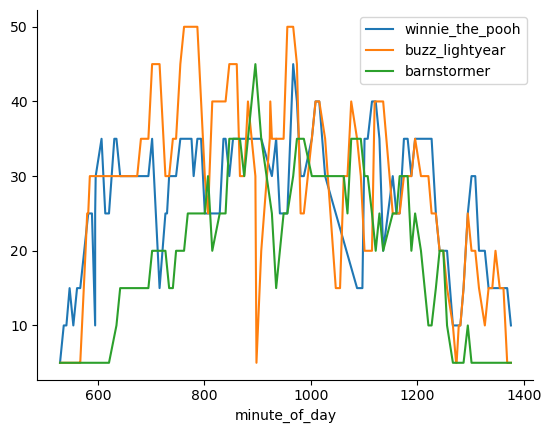

In [6]:
attractions = ['winnie_the_pooh', 'buzz_lightyear', 'barnstormer']
date = '01/01/2017'

fig, ax = plot_postwait_per_day(df_post, attractions, date)
ax.spines[['top', 'right']].set_visible(False)

## Step 3: Study for which attractions we have sufficient information for posted waiting time.

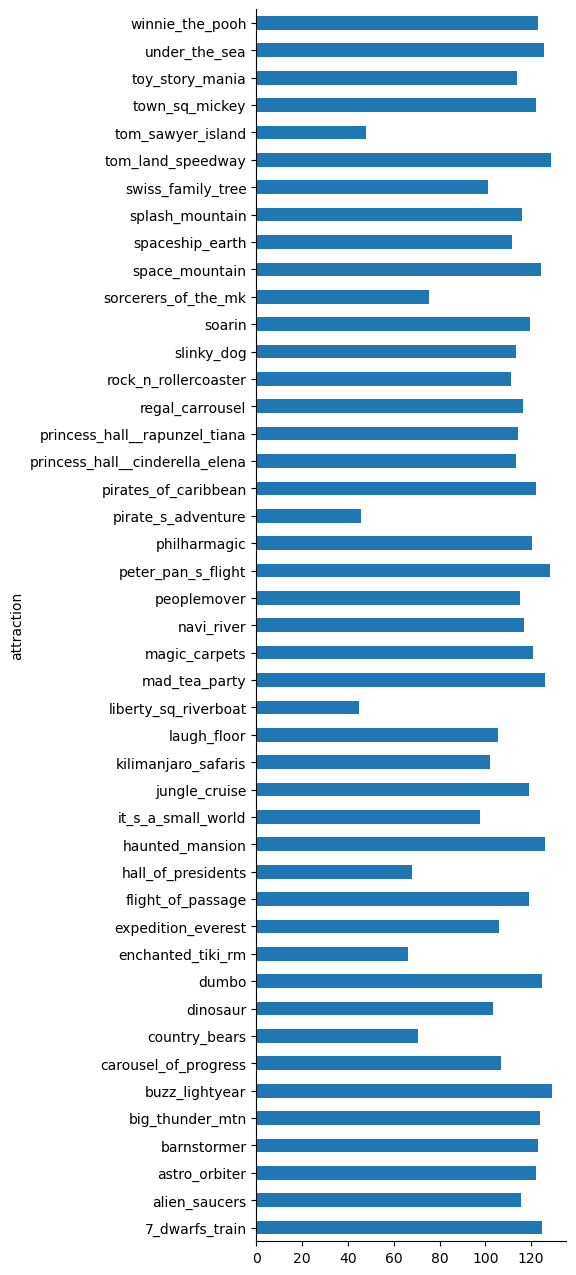

In [7]:
rows = list()
# This can be done more efficiently using ".size" but this is more explicit.
for (attraction, date), group in df_post.groupby(['attraction', 'date']):
    rows.append({
        'attraction' : attraction,
        'date' : date,
        'count' : len(group)
    })

df_num_post_wait = pd.DataFrame(rows)

# Would be even better if we sorted the bars based on width
fig, ax = plt.subplots(figsize = (4, 16))
(df_num_post_wait.groupby('attraction')['count']
                 .mean()
                 .plot
                 .barh(ax = ax))

ax.spines[['right', 'top']].set_visible(False)

## Step 4: Study the distribution of data availability for actual waiting time information.

In [8]:
print(f"Actuals consist of only {int(len(df_act) / len(df_post) * 100)}% of the data")

Actuals consist of only 2% of the data


#### How many actuals do we have per day per attraction

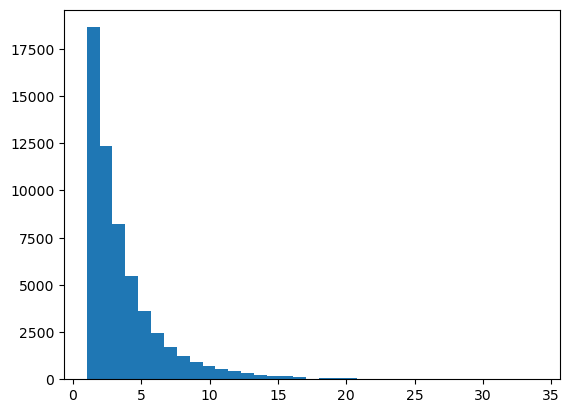

In [9]:
plt.hist(df_act.groupby(['date', 'attraction']).size().values, bins = 35);

## Research Question 1: Compare predicted and actual waiting time

In [10]:
## You can also use df.interpolate(, method = 'linear')
groups_post = {(date, attraction) : group for (date,attraction), group in df_post.groupby(['date', 'attraction'])}

dfs_error = list()
for (date, attraction), group_act in tqdm(df_act.groupby(['date', 'attraction'])):
    if (date, attraction) not in groups_post:
        continue

    group_post = groups_post[(date, attraction)]
    fun_int = interp1d(group_post['minute_of_day'], group_post['SPOSTMIN'])
    
    group_act = group_act.loc[(group_post.minute_of_day.min() <= group_act.minute_of_day) 
                                & (group_act.minute_of_day <= group_post.minute_of_day.max())]
    group_act['SPOSTMIN'] = fun_int(group_act['minute_of_day'])
    group_act['error'] = group_act['SPOSTMIN'] - group_act['SACTMIN']
    dfs_error.append(group_act.copy())
df_error = pd.concat(dfs_error)

  0%|          | 1/57579 [00:00<2:11:47,  7.28it/s]C:\Users\timH\AppData\Local\Temp\ipykernel_13388\4284940074.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group_act['SPOSTMIN'] = fun_int(group_act['minute_of_day'])
C:\Users\timH\AppData\Local\Temp\ipykernel_13388\4284940074.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group_act['error'] = group_act['SPOSTMIN'] - group_act['SACTMIN']
C:\Users\timH\AppData\Local\Temp\ipykernel_13388\4284940074.py:14: SettingWithCopyWarning: 
A value is trying

In [142]:
plt.hist(df_error['error'])

KeyboardInterrupt: 

In [ ]:
fun_int(479)

array(55.90909091)

In [ ]:
group_act

,date,datetime,SACTMIN,attraction,minute_of_day,SPOSTMIN,error
0,01/01/2015,2015-01-01 08:05:30,54.0,7_dwarfs_train,485,60.0,6.0
1,01/01/2015,2015-01-01 08:22:16,55.0,7_dwarfs_train,502,60.0,5.0
